## Import Libraries

In [114]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Load the Data

In [115]:
df = pd.read_csv("clear_data.csv")

In [116]:
df.shape

(6529, 18)

In [117]:
df.drop('Unnamed: 0', axis=1 ,inplace=True)


In [118]:
df.head(2)

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Left-Back,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,4,35000000,42000000,2,1
1,Manchester United,Defender Left-Back,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,3,22000000,22000000,2,1


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [119]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [120]:
df['age']=df['age'].astype(int)
df['height'] = df['height'].astype(int)

In [121]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = [ 'team','position']
numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards','second yellow cards', 'red cards', 'goals conceded','clean sheets', 'minutes played','days_injured','games_injured','award','current_value','highest_value','position_encoded','winger']

In [122]:
for i in categorical_features:
    print(df[i].value_counts())

team
Royal AM FC               30
Al-Batin FC               28
Gangwon FC                28
Daejeon Hana Citizen      28
Jeonbuk Hyundai Motors    28
                          ..
Swansea City              12
Manchester City           11
Paris Saint-Germain       11
Gaziantep FK               5
Hatayspor                  5
Name: count, Length: 374, dtype: int64
position
Attack Centre-Forward         1294
midfield-CentralMidfield      1106
midfield-DefensiveMidfield     867
Defender Left-Back             774
midfield-AttackingMidfield     745
Attack-RightWinger             695
Attack-LeftWinger              694
midfield-RightMidfield          97
midfield-LeftMidfield           97
Attack-SecondStriker            62
midfield                        58
Attack                          40
Name: count, dtype: int64


In [123]:
df.dtypes

team                 object
position             object
height                int64
age                   int64
appearance            int64
goals               float64
assists             float64
red cards           float64
clean sheets        float64
minutes played        int64
days_injured          int64
games_injured         int64
award                 int64
current_value         int64
highest_value         int64
position_encoded      int64
winger                int64
dtype: object

In [124]:
df.head(2)

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Left-Back,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,4,35000000,42000000,2,1
1,Manchester United,Defender Left-Back,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,3,22000000,22000000,2,1


In [125]:
df.shape

(6529, 17)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [126]:
categorical_features

['team', 'position']

In [127]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features,drop_first=1)

In [128]:
df.shape

(6529, 399)

In [129]:
df.head(2)

,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,...,position_Attack-LeftWinger,position_Attack-RightWinger,position_Attack-SecondStriker,position_Defender Left-Back,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,...,False,False,False,True,False,False,False,False,False,False
1,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,...,False,False,False,True,False,False,False,False,False,False


#### 3. Feature selection

In [130]:
correlation = df.corr()
print(correlation['current_value'].sort_values(ascending=False))

current_value                      1.000000
highest_value                      0.839764
minutes played                     0.431664
appearance                         0.417284
award                              0.285266
                                     ...   
position_midfield-RightMidfield   -0.029469
position_Defender Left-Back       -0.038949
position_midfield                 -0.039939
age                               -0.047510
clean sheets                            NaN
Name: current_value, Length: 399, dtype: float64


In [131]:
# Set the correlation threshold
threshold = 0.25 # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['appearance', 'minutes played', 'award', 'current_value',
       'highest_value'],
      dtype='object')

In [132]:
selected_features = ['age', 'appearance', 'minutes played', 'current_value', 'highest_value', 'team_AFC Bournemouth', 'team_RC Strasbourg Alsace', 'team_Stade Rennais FC']

In [133]:
df = df[selected_features]
df.head()

,age,appearance,minutes played,current_value,highest_value,team_AFC Bournemouth,team_RC Strasbourg Alsace,team_Stade Rennais FC
0,27,74,5854,35000000,42000000,False,False,False
1,23,89,7132,22000000,22000000,False,False,False
2,22,34,2686,10000000,12000000,False,False,False
3,31,101,7928,50000000,80000000,False,False,False
4,26,76,4687,25000000,35000000,False,False,False


#### 4. Prepare train and test data

In [134]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.05,
                                                    shuffle=True,
                                                    random_state=134)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [135]:
X.shape

(6529, 7)

## Buliding the Model

In [136]:
random_model = RandomForestClassifier()
Trre_model = DecisionTreeClassifier()

## Train the Model

In [137]:
# Fit the model on the training data
random_model.fit(X_train_scaled, y_train)

RandomForestClassifier()

## Test the Model

In [138]:
# Predict and evaluate the model
y_pred = random_model.predict(X_test_scaled)

In [139]:
Trre_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [140]:
y_pred_Tree= Trre_model.predict(X_test_scaled)


In [141]:
print("Best parameters found: ", grid_search_ridge.best_params_)

# Best model
best_ridge = grid_search_ridge.best_estimator_

Best parameters found:  {'alpha': 5}


In [142]:
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best model
best_lasso = grid_search_lasso.best_estimator_


Best parameters found:  {'alpha': 6}


In [143]:
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)


In [144]:
y_pred_lasso_cv = best_lasso.predict(X_test_scaled)


## Interpretation of the Model

## Evaluating the Model 

1. Mean Square Error

In [145]:
y_base = [y_train.mean()] * len(y_test)

In [146]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 113861329221917.06


In [147]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 21838575375216.438
Mean Squared Error for testing: 19729139908256.88


2. Mean Absolute Error

In [148]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 4974187.842138326


In [149]:
mae_train = mean_absolute_error(y_train, random_model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 205.5788455336988
Mean Absolute Error for testing: 1350764.5259938838


3. Root Mean Squared Error

In [150]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 2230.2887351503


In [151]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 4673176.1549524795
Root Mean Squared Error for testing: 4441749.644932375


4. R Square

In [152]:
r2_score_train = r2_score(y_train, Trre_model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.9999988101135475
R Square for testing: 0.8264621247224715


#### Predictions vs. Real Values

In [153]:
predictions = random_model.predict(X_test_scaled)
#predictions

In [154]:
predictions_Trre = Trre_model.predict(X_test_scaled)


In [155]:
Real_Values = np.array(y_test)
#Real_Values

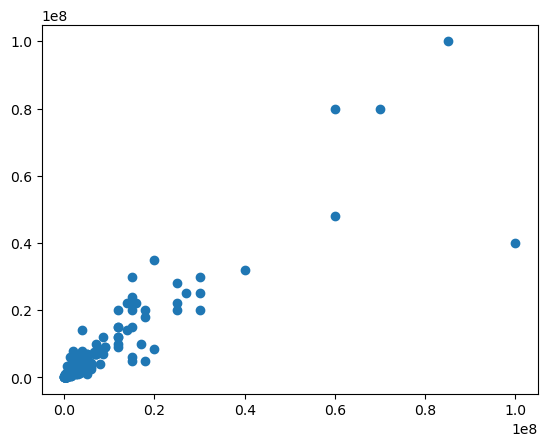

In [156]:
plt.scatter(Real_Values,predictions); 

In [157]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.37920489296636084

In [158]:
y_pred_Tree = Trre_model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_Tree)
accuracy

0.999032570138665

In [159]:
y_pred_random = random_model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_random)
accuracy

0.999032570138665

#### Residual Histogram

In [160]:
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")


Precision: 0.2348


In [161]:
y_pred_train = random_model.predict(X_train_scaled)
precision = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 1.00


In [162]:
y_pred_train = Trre_model.predict(X_train_scaled)
precision = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 1.00


In [163]:
y_pred_train = random_model.predict(X_train_scaled)
recall = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 1.00


In [164]:
y_pred_train = Trre_model.predict(X_train_scaled)
recall = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 1.00


In [165]:
y_pred_train = random_model.predict(X_train_scaled)
f1 = f1_score(y_train,y_pred_train,average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 1.00


In [166]:
y_pred_train = Trre_model.predict(X_train_scaled)
f1 = f1_score(y_train,y_pred_train,average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 1.00
